In [2]:
from os import listdir
import pandas as pd
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from typing import List, Optional

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdMolDescriptors, MolFromSmiles, MolToSmiles
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
remover = SaltRemover()
from rdkit.Chem.rdmolfiles import MolFromPDBBlock
from rdkit.Chem.rdPartialCharges import ComputeGasteigerCharges
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings
import py3Dmol

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
mpl.rcParams['figure.dpi'] = 150
filenames = [ f for f in listdir('data/') if f[-4:]=='.pdb']

In [3]:
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
df = pd.read_csv('data/Mpro_hits_summary.csv')
df = df.set_index('Dataset')

In [ ]:
all_ligands = []
for f in tqdm(filenames):
    dataname = f[:-6]
    smiles = df.loc[dataname]['Compound SMILES']
    file = open(f, 'r')
    data = file.read().splitlines()
    ligand = [line for line in data if 'LIG' in line and 'HETATM' in line]
    ligand_data = [smiles]
    for atom in ligand:
        #print(atom)
        details = atom.split()
        #print(details)
        species = details[-1]
        xyz = [float(i) for i in details[-6:-3]]
        ligand_data.append([species, xyz])
    all_ligands.append(ligand_data)

### Using RDKit directly

In [ ]:
print(filenames)

In [ ]:
all_ligands = []
for f in tqdm(filenames):
    dataname = f[:-6]
    
    smiles = df.loc[dataname]['Compound SMILES']
    template = AllChem.MolFromSmiles(smiles)
    template = remover.StripMol(template)
    
    file = open('data/'+f, 'r')
    data = file.read().splitlines()
    ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
    
    pdbblock = ''.join(ligand)
    read_mol = MolFromPDBBlock(pdbblock)
    newMol = AllChem.AssignBondOrdersFromTemplate(template, read_mol)

    conf = newMol.GetConformer()
    
    ComputeGasteigerCharges(newMol)
    
    ligand_data = [MolToSmiles(template)]
    
    
    atom_map = []
    for i,a in enumerate(newMol.GetAtoms()):
        atom_map.append((i,i))
    
    m2=Chem.AddHs(newMol)

    #m2=newMol

    AllChem.EmbedMolecule(m2)
    AllChem.UFFOptimizeMolecule(m2)
    RMSD = Chem.rdMolAlign.AlignMol(m2, newMol, atomMap = atom_map)
    conf = newMol.GetConformer()


    print('\nRMSD after aligning = {}'.format(RMSD))
    
    #Chem.rdForceFieldHelpers.UFFOptimizeMolecule(m2)
    conf2 = m2.GetConformer()
    ComputeGasteigerCharges(m2)

#     tot_charge = 0
#     for i,a in enumerate(newMol.GetAtoms()):
#         print([a.GetSymbol(),conf.GetPositions()[i], float(a.GetProp('_GasteigerCharge')) + float(a.GetProp('_GasteigerHCharge'))])
#         tot_charge += float(a.GetProp('_GasteigerCharge')) + float(a.GetProp('_GasteigerHCharge'))
#         ligand_data.append([a.GetSymbol(),conf.GetPositions()[i], float(a.GetProp('_GasteigerCharge'))])
        
#     print(tot_charge)
#     print('\nm2')
#     tot_charge = 0
    
    for j,atom in enumerate(m2.GetAtoms()):
#         print([atom.GetSymbol(),conf2.GetPositions()[j], float(atom.GetProp('_GasteigerCharge'))])
        ligand_data.append([atom.GetSymbol(),conf2.GetPositions()[j], float(atom.GetProp('_GasteigerCharge'))])

        
        
#     print(tot_charge)
#         all_ligands.append([a.GetSymbol(),conf.GetPositions()[i], float(a.GetProp('_GasteigerCharge'))])

    all_ligands.append(ligand_data)
        
#     ligand_data = [smiles]
#     print('PDB file')
#     for atom in ligand:
# #         print(atom)
#         details = atom.rstrip()
#         #print(details)
#         species = details[-2:].lstrip()
#         x = float(details[32:38])
#         y = float(details[38:46])
#         z = float(details[46:54])

#         xyz = np.array([x,y,z])
#         print(species, xyz)
#         ligand_data.append([species, xyz])
#     all_ligands.append(ligand_data)
# p_charges = [atom[2] for atom in all_ligands]
# N=30
# inds = np.argpartition(p_charges, -N)[-N:]
# for ind in inds:
#     print(all_ligands[ind])

### Better alignment (using Joshua Myers code)

In [5]:
def duplicate_conformers(m: Chem.rdchem.Mol, new_conf_idx: int, rms_limit: float = 0.5) -> bool:
    rmslist = []
    for i in range(m.GetNumConformers()):
        if i == new_conf_idx:
            continue
        rms = AllChem.GetConformerRMS(m, new_conf_idx, i, prealigned=True)
        rmslist.append(rms)
    return any(i < rms_limit for i in rmslist)


def get_mcs(mol_one: Chem.rdchem.Mol, mol_two: Chem.rdchem.Mol) -> str:
    """Code to find the maximum common substructure between two molecules."""
    return Chem.MolToSmiles(
        Chem.MolFromSmarts(
            rdFMCS.FindMCS([mol_one,mol_two], completeRingsOnly=True, matchValences=True).smartsString
        )
    )


def generate_conformers(mol: Chem.rdchem.Mol,
                        ref_mol: Chem.rdchem.Mol,
                        num_conf: int,
                        ref_smi: str = None,
                        minimum_conf_rms: Optional[float] = None,
                       ) -> List[Chem.rdchem.Mol]:
    # if SMILES to be fixed are not given, assume to the MCS
    if not ref_smi:
        ref_smi = get_mcs(mol, ref_mol)
    print('Aligning {}'.format(ref_smi))
    # Creating core of reference ligand #
    try:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(ref_smi))

        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol
    except Exception as ex:
        core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(get_mcs(mol, ref_mol)))
        core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
        core.UpdatePropertyCache()

        # Add Hs so that conf gen is improved
        mol.RemoveAllConformers()
        mol = Chem.AddHs(mol)

        # Generate conformers with constrained embed
        dup_count = 0
        for i in range(num_conf):
            temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, ignoreSmoothingFailures=True,useRandomCoords=True,useTethers=True,randomseed=i)
            conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
            if minimum_conf_rms is not None:
                if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                    dup_count += 1
                    mol.RemoveConformer(conf_idx)
        if dup_count:
            print(f'removed {dup_count} duplicated conformations')
        return mol

In [6]:
import Bio.PDB as PDB

class ProteinLigandClashFilter:
    def __init__(self, protein_pdbpath: str, distance: float = 1.5):
        parser = PDB.PDBParser(QUIET=True, PERMISSIVE=True)
        s = parser.get_structure('protein', protein_pdbpath)
        self.kd = PDB.NeighborSearch(list(s.get_atoms()))
        self.radius = distance

    def __call__(self, conf: Chem.rdchem.Conformer) -> bool:
        for coord in conf.GetPositions():
            res = self.kd.search(coord, radius=self.radius)
            if len(res):
                return True
        return False

In [ ]:
pdb_path = 'data/Mpro-x0072_0_new.pdb'
clash_filter = ProteinLigandClashFilter(pdb_path, distance=0.5)

# generate a mask and filter clashing confs from list
for conf in mol.GetConformers():
    if clash_filter(conf):
        confid = conf.GetId()
        print(f'removing conformer id: {confid}')
        mol.RemoveConformer(confid)
print(mol.GetNumConformers(), 'conformers remaining')

In [ ]:
# load PDB with waters and ligand deleted (kept single structural water)
pdb = Chem.MolFromPDBFile(pdb_path)

chA = {'chain':'A'}
view = py3Dmol.view()
view.addModel(Chem.MolToPDBBlock(pdb), 'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, chA)

n = -1
for n, conf in enumerate(mol.GetConformers()):
    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
    view.addModel(mb, 'sdf')
    view.setStyle({'model': n+1}, {'stick': {}})

view.setBackgroundColor('0xeeeeee')
view.zoomTo({'model': n+1})
view.show()

In [7]:
aligned_mols = []
all_ligands = []
for f in tqdm(filenames):
    dataname = f[:-6]
    print(dataname)
    
    smiles = df.loc[dataname]['Compound SMILES']
    mol = AllChem.MolFromSmiles(smiles)
    mol = remover.StripMol(mol)
    smiles = MolToSmiles(mol)

    file = open('data/'+f, 'r')
    data = file.read().splitlines()
    ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
    
    pdbblock = ''.join(ligand)
    read_mol = MolFromPDBBlock(pdbblock)
    ref_mol = AllChem.AssignBondOrdersFromTemplate(mol, read_mol)
    
    mol = Chem.AddHs(mol)
    mol = generate_conformers(mol, ref_mol, 100, ref_smi = smiles, minimum_conf_rms=0.5)

    #mol = generate_conformers(mol, ref_mol, 100, minimum_conf_rms=0.5)

    print('Remaining conformations: {}'.format(mol.GetNumConformers()))
    aligned_mols.append(mol)
    
    conf = mol.GetConformer()
    ComputeGasteigerCharges(mol)
    
    Z = []
    xyz = []
    for j,atom in enumerate(mol.GetAtoms()):
        Z.append(Z_numbers[atom.GetSymbol()])
        xyz.append(conf.GetPositions()[j])
        
    charges, _, \
       _, _, _, \
       _, _, _, _, _  = compute_partial_charges(Z, xyz)
    
    ligand_data = [smiles]
    for j,atom in enumerate(mol.GetAtoms()):
        ligand_data.append([atom.GetSymbol(),conf.GetPositions()[j], float(atom.GetProp('_GasteigerCharge')), charges[j]])
        
    all_ligands.append(ligand_data)

  0%|          | 0/23 [00:00<?, ?it/s]

Mpro-x0305
Aligning CCNc1ccc(C#N)cn1


  0%|          | 0/23 [00:03<?, ?it/s]

removed 88 duplicated conformations
Remaining conformations: 12


NameError: name 'Z_numbers' is not defined

In [ ]:
n=21
mol = aligned_mols[n]
print(MolToSmiles(Chem.RemoveHs(mol)))
# visualise confs
view = py3Dmol.view()
for i in range(mol.GetNumConformers()):
    mb = Chem.MolToMolBlock(mol, confId=i)
    view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view

### Plot atom positions (coloured by fragment identity)

<IPython.core.display.Javascript object>


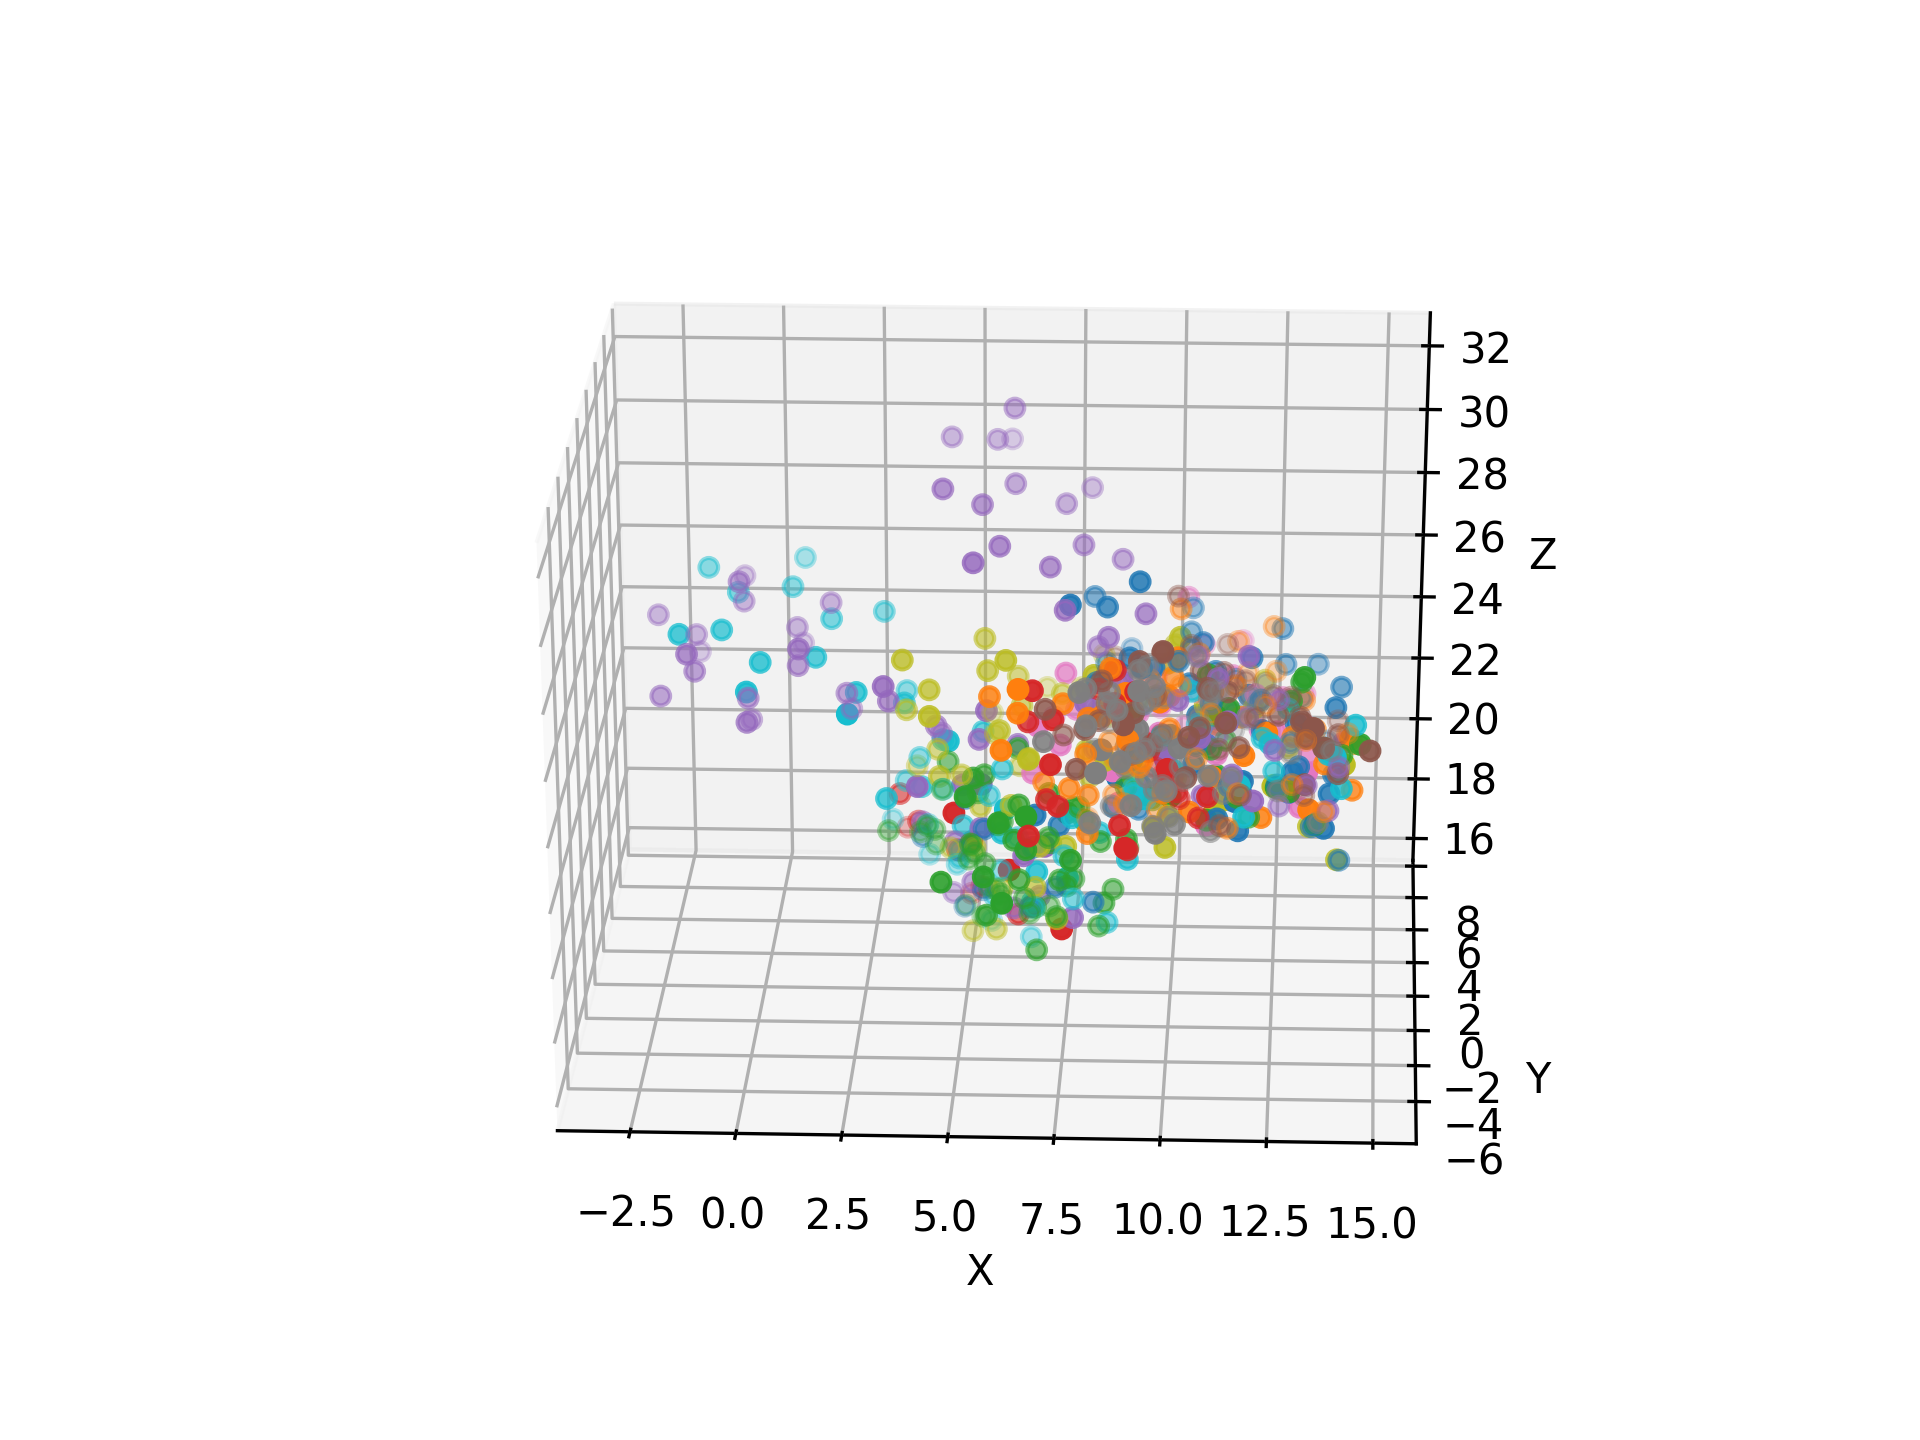

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for ligand in all_ligands:
    xyz=[]
    for atom in ligand[1:]:
        xyz.append(np.array(atom[1]))
    xyz = np.array(xyz).T

    ax.scatter(xyz[0], xyz[1], xyz[2])

### Plot Gasteiger charges from all fragments 

<IPython.core.display.Javascript object>


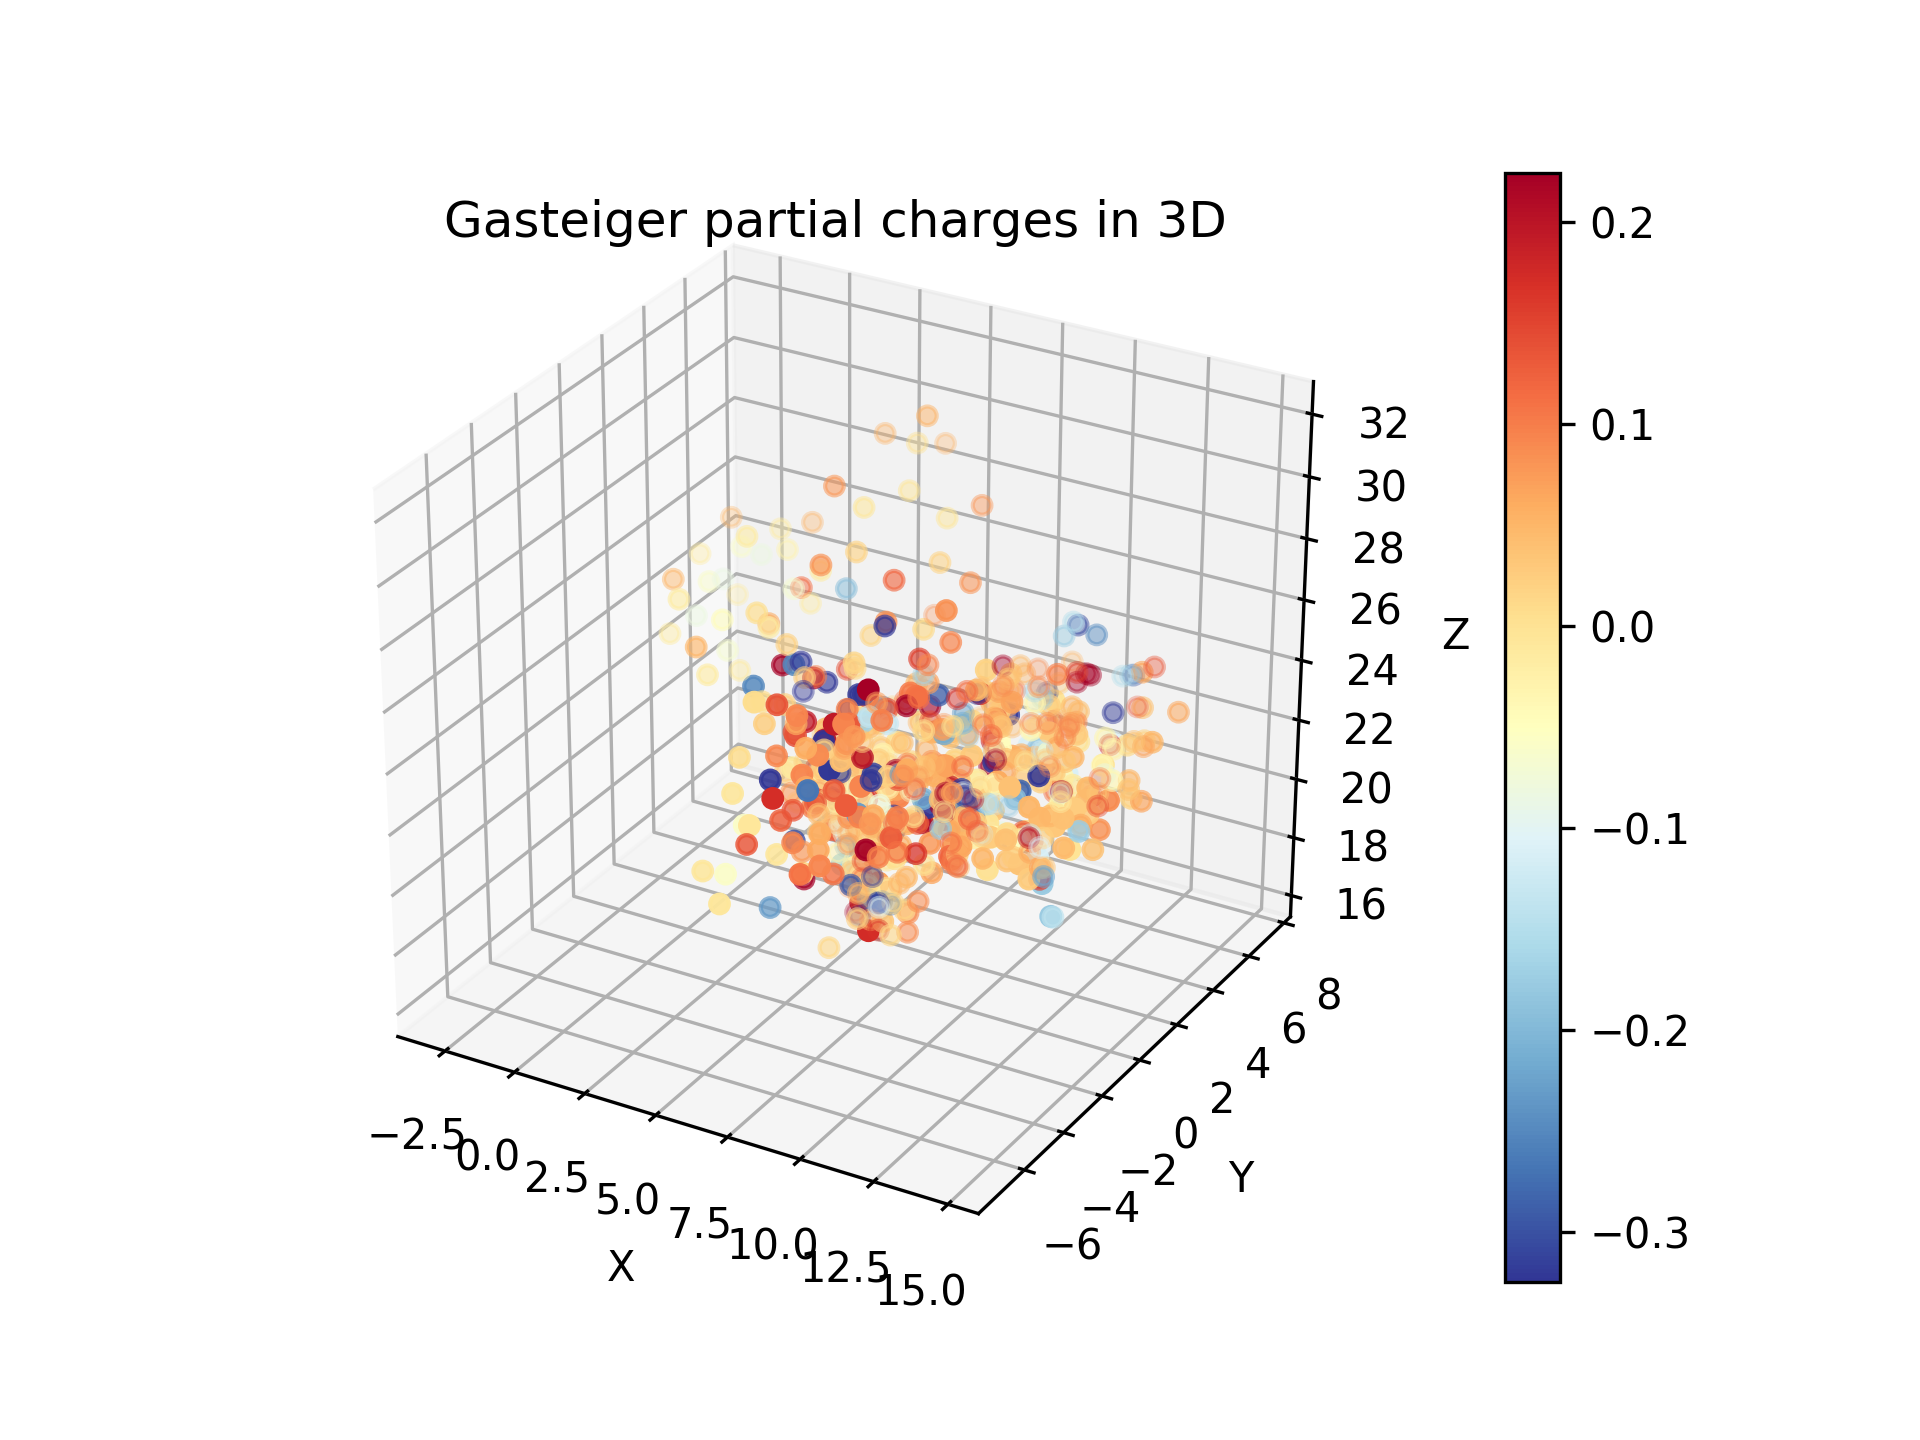

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Gasteiger partial charges in 3D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cm = plt.cm.get_cmap('RdYlBu_r')

for ligand in all_ligands:
    xyz=[]
    p_charges=[]
    for atom in ligand[1:]:
        xyz.append(np.array(atom[1]))
        p_charges.append(atom[2])
    xyz = np.array(xyz).T
    im = ax.scatter(xyz[0], xyz[1], xyz[2], c=p_charges, cmap=cm)
cbar = fig.colorbar(im)

In [75]:
charges = []
for ligand in all_ligands:
    for atom in ligand[1:]:
        charges.append(atom)

def evaluate_potential(xyz):
    potential = 0
    for charge in charges:
        r = np.linalg.norm(xyz-charge[1])
        potential += charge[2]*np.exp(-r/7)/r
    return potential

def test_func(xyz):
    return np.mean(xyz)
    
# calculate grid of potential energy
nx, ny, nz = (10, 10, 10)

x = np.linspace(-4, 16, nx)
y = np.linspace(-8, 8, ny)
z = np.linspace(14, 32, nz)
xv, yv, zv = np.meshgrid(x, y, z)

xv = xv.flatten().reshape(-1,1)
yv = yv.flatten().reshape(-1,1)
zv = zv.flatten().reshape(-1,1)
all_coords = np.hstack([xv,yv,zv])

potential = np.apply_along_axis(evaluate_potential,1, all_coords)

<IPython.core.display.Javascript object>


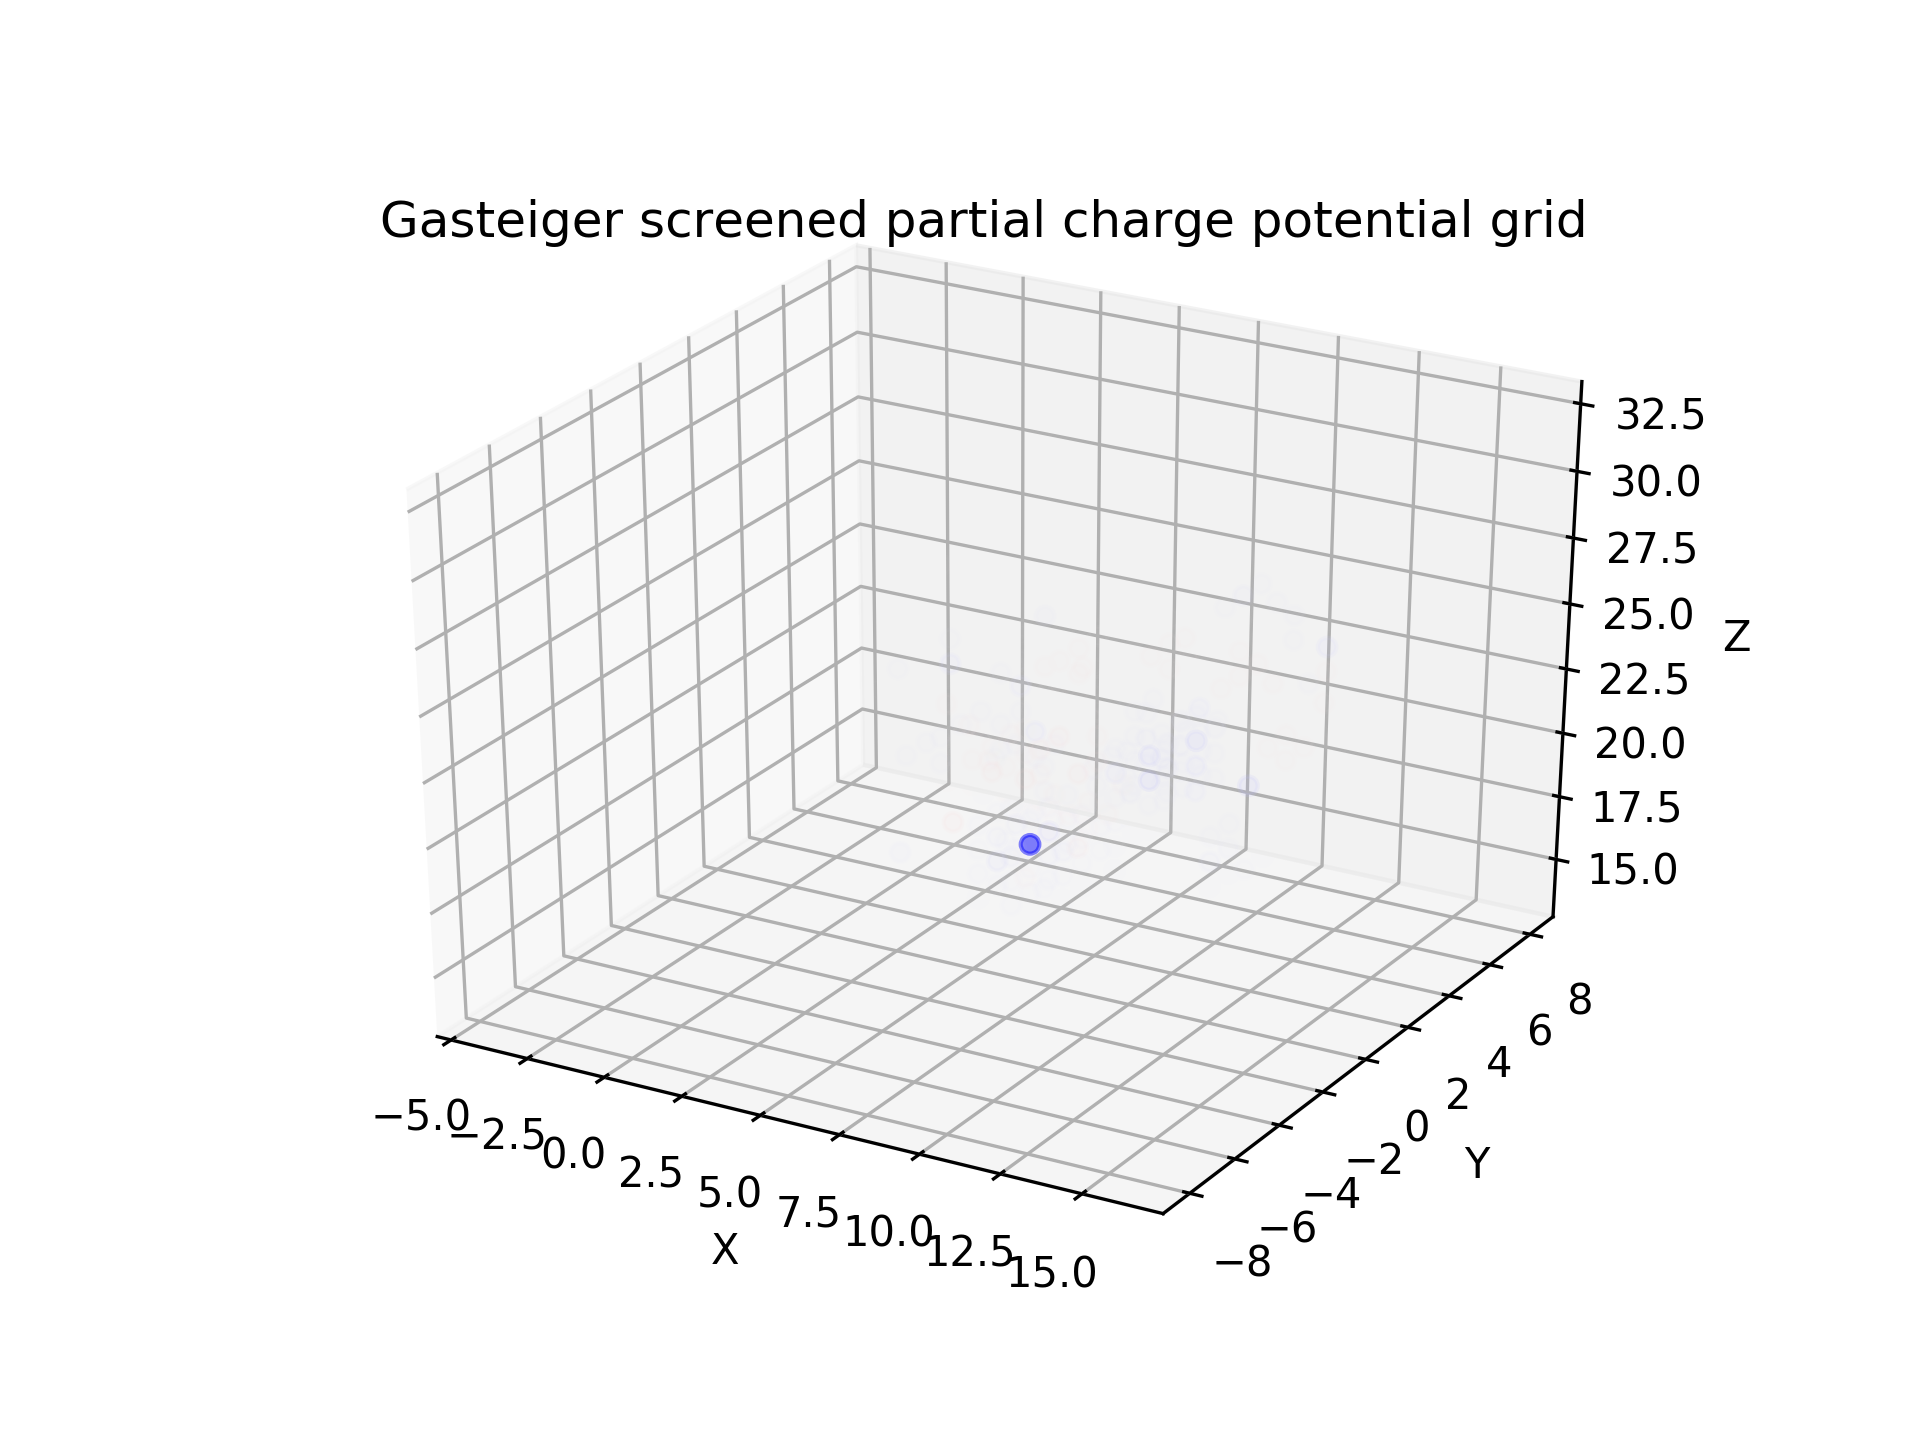

In [80]:
vmin = potential.min()
vmax = potential.max()

norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Gasteiger screened partial charge potential grid')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cm = plt.cm.get_cmap('bwr')


#colors = np.zeros((len(xv),4))
colors = cm(norm(potential))
alphas = np.abs(potential)/(vmax-vmin)
#colors[:,0] = cm(potential).T[0]
colors[:,3] = alphas
#print(colors)
#for i, j in enumerate(xv):
im = ax.scatter(xv, yv, zv, c=colors)#alpha=(potential[i]-vmin)/(vmax-vmin))

### Do PM7 charges instead

In [81]:
from md_sampling import compute_partial_charges
Z_numbers={'H':1,'He':2,'Li':3,'Be':4,'B':5,'C':6,'N':7,'O':8,'F':9,'Ne':10,'Na':11,'Mg':12,'Al':13,'Si':14,'P':15,'S':16,'Cl':17,'Ar':18,
                       'K':19,'Ca':20,'Sc':21,'Ti':22,'V':23,'Cr':24,'Mn':25,'Fe':26,'Co':27,'Ni':28,'Cu':29,'Zn':30,'Ga':31,'Ge':32,'As':33,'Se':34,
                       'Br':35,'Kr':36,'Rb':37,'Sr':38,'Y':39,'Zr':40,'Nb':41,'Mo':42,'Tc':43,'Ru':44,'Rh':45,'Pd':46,'Ag':47,'Cd':48,'In':49,'Sn':50,
                       'Sb':51,'Te':52,'I':53,'Xe':54,'Cs':55,'Ba':56,'La':57,'Ce':58,'Pr':59,'Nd':60,'Pm':61,'Sm':62,'Eu':63,'Gd':64,'Tb':65,'Dy':66,
                       'Ho':67,'Er':68,'Tm':69,'Yb':70,'Lu':71,'Hf':72,'Ta':73,'W':74,'Re':75,'Os':76,'Ir':77,'Pt':78,'Au':79,'Hg':80,'Tl':81,'Pb':82,
                       'Bi':83,'Po':84,'At':85,'Rn':86,'Fr':87,'Ra':88,'Ac':89,'Th':90,'Pa':91,'U':92,'Np':93,'Pu':94,'Am':95,'Cm':96,'Bk':97,'Cf':98,
                       'Es':99,'Fm':100,'Md':101,'No':102,'Lr':103,'Rf':104,'Db':105,'Sg':106,'Bh':107,'Hs':108,'Mt':109,'Ds':110,'Rg':111,'Cn':112,
                       'Uut':113,'Uuq':114,'Uup':115,'Uuh':116,'Uus':117,'Uuo':118}


In [ ]:
all_ligands = []
for f in tqdm(filenames):
    dataname = f[:-6]
    
    smiles = df.loc[dataname]['Compound SMILES']
    template = AllChem.MolFromSmiles(smiles)
    template = remover.StripMol(template)
    
    file = open('data/'+f, 'r')
    data = file.read().splitlines()
    ligand = [line+'\n' for line in data if 'LIG' in line and 'HETATM' in line]
    
    pdbblock = ''.join(ligand)
    read_mol = MolFromPDBBlock(pdbblock)
    newMol = AllChem.AssignBondOrdersFromTemplate(template, read_mol)

    conf = newMol.GetConformer()
    
    ComputeGasteigerCharges(newMol)
    
    ligand_data = [MolToSmiles(template)]
    
    
    atom_map = []
    for i,a in enumerate(newMol.GetAtoms()):
        atom_map.append((i,i))
    
    m2=Chem.AddHs(newMol)

    AllChem.EmbedMolecule(m2)
    AllChem.UFFOptimizeMolecule(m2)
    RMSD = Chem.rdMolAlign.AlignMol(m2, newMol, atomMap = atom_map)
    conf = newMol.GetConformer()


    print('\nRMSD after aligning = {}'.format(RMSD))
    
    conf2 = m2.GetConformer()
    
    Z = []
    xyz = []
    for j,atom in enumerate(m2.GetAtoms()):
        Z.append(Z_numbers[atom.GetSymbol()])
        xyz.append(conf2.GetPositions()[j])
        
    charges, _, \
       _, _, _, \
       _, _, _, _, _  = compute_partial_charges(Z, xyz)
    for j,atom in enumerate(m2.GetAtoms()):
        ligand_data.append([atom.GetSymbol(),conf2.GetPositions()[j], charges[j]])
        
    all_ligands.append(ligand_data)

<IPython.core.display.Javascript object>


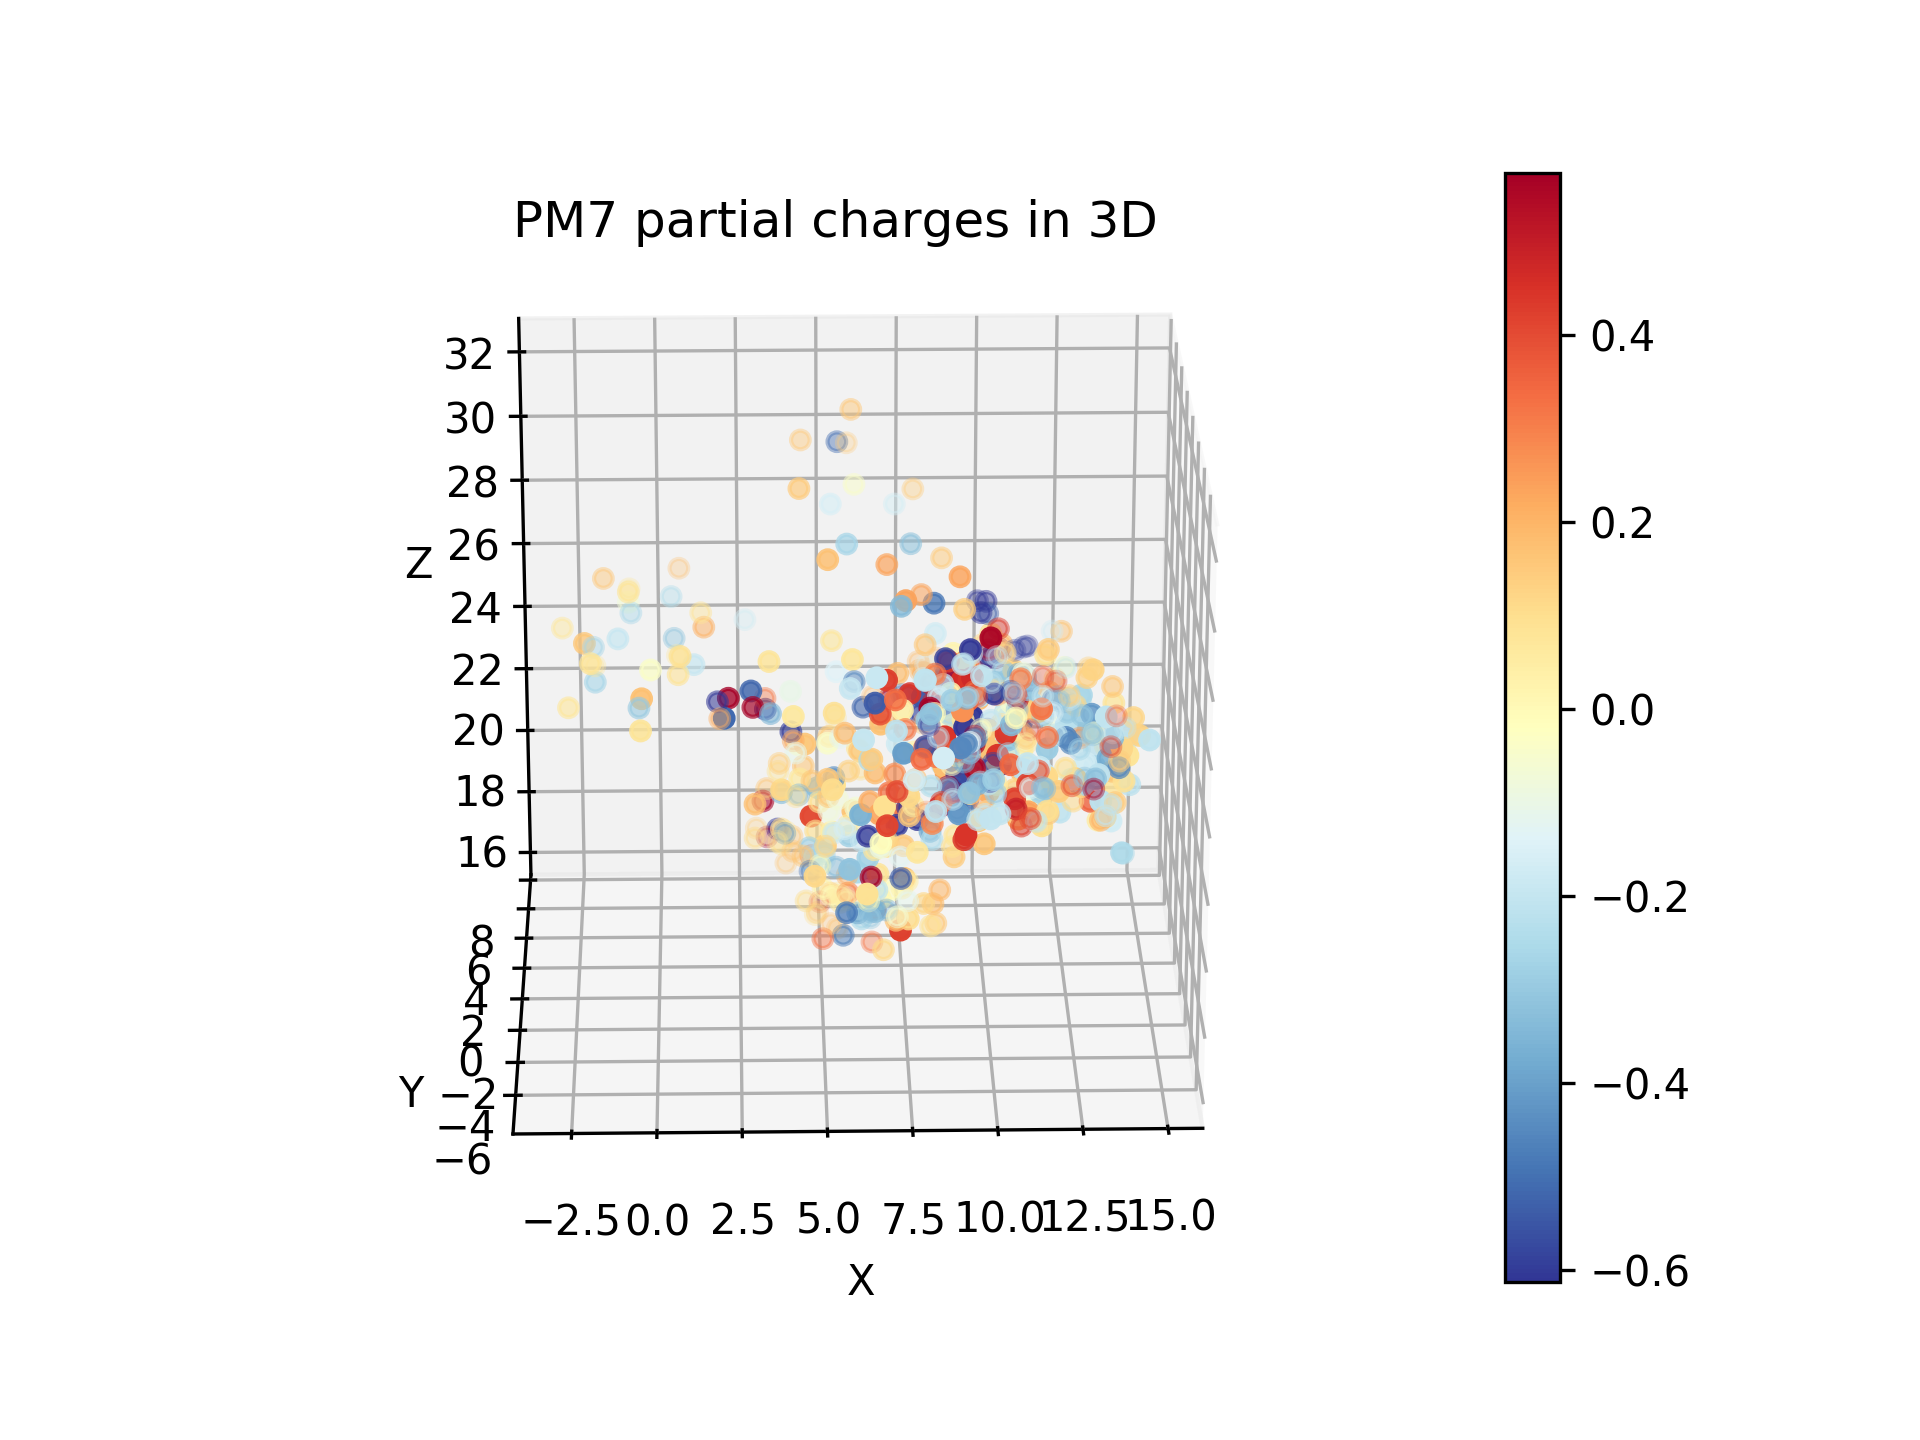

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PM7 partial charges in 3D')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cm = plt.cm.get_cmap('RdYlBu_r')

for ligand in all_ligands:
    xyz=[]
    p_charges=[]
    for atom in ligand[1:]:
        xyz.append(np.array(atom[1]))
        p_charges.append(atom[3])
    xyz = np.array(xyz).T
    im = ax.scatter(xyz[0], xyz[1], xyz[2], c=p_charges, cmap=cm)
cbar = fig.colorbar(im)

In [98]:
charges = []
for ligand in all_ligands:
    for atom in ligand[1:]:
        charges.append(atom)

def evaluate_potential(xyz):
    potential = 0
    for charge in charges:
        r = np.linalg.norm(xyz-charge[1])
        potential += charge[3]*np.exp(-r/7)/r
    return potential

def test_func(xyz):
    return np.mean(xyz)
    
# calculate grid of potential energy
nx, ny, nz = (20, 20, 20)

x = np.linspace(-4, 16, nx)
y = np.linspace(-8, 8, ny)
z = np.linspace(14, 32, nz)
xv, yv, zv = np.meshgrid(x, y, z)

xv = xv.flatten().reshape(-1,1)
yv = yv.flatten().reshape(-1,1)
zv = zv.flatten().reshape(-1,1)
all_coords = np.hstack([xv,yv,zv])

potential = np.apply_along_axis(evaluate_potential,1, all_coords)

<IPython.core.display.Javascript object>


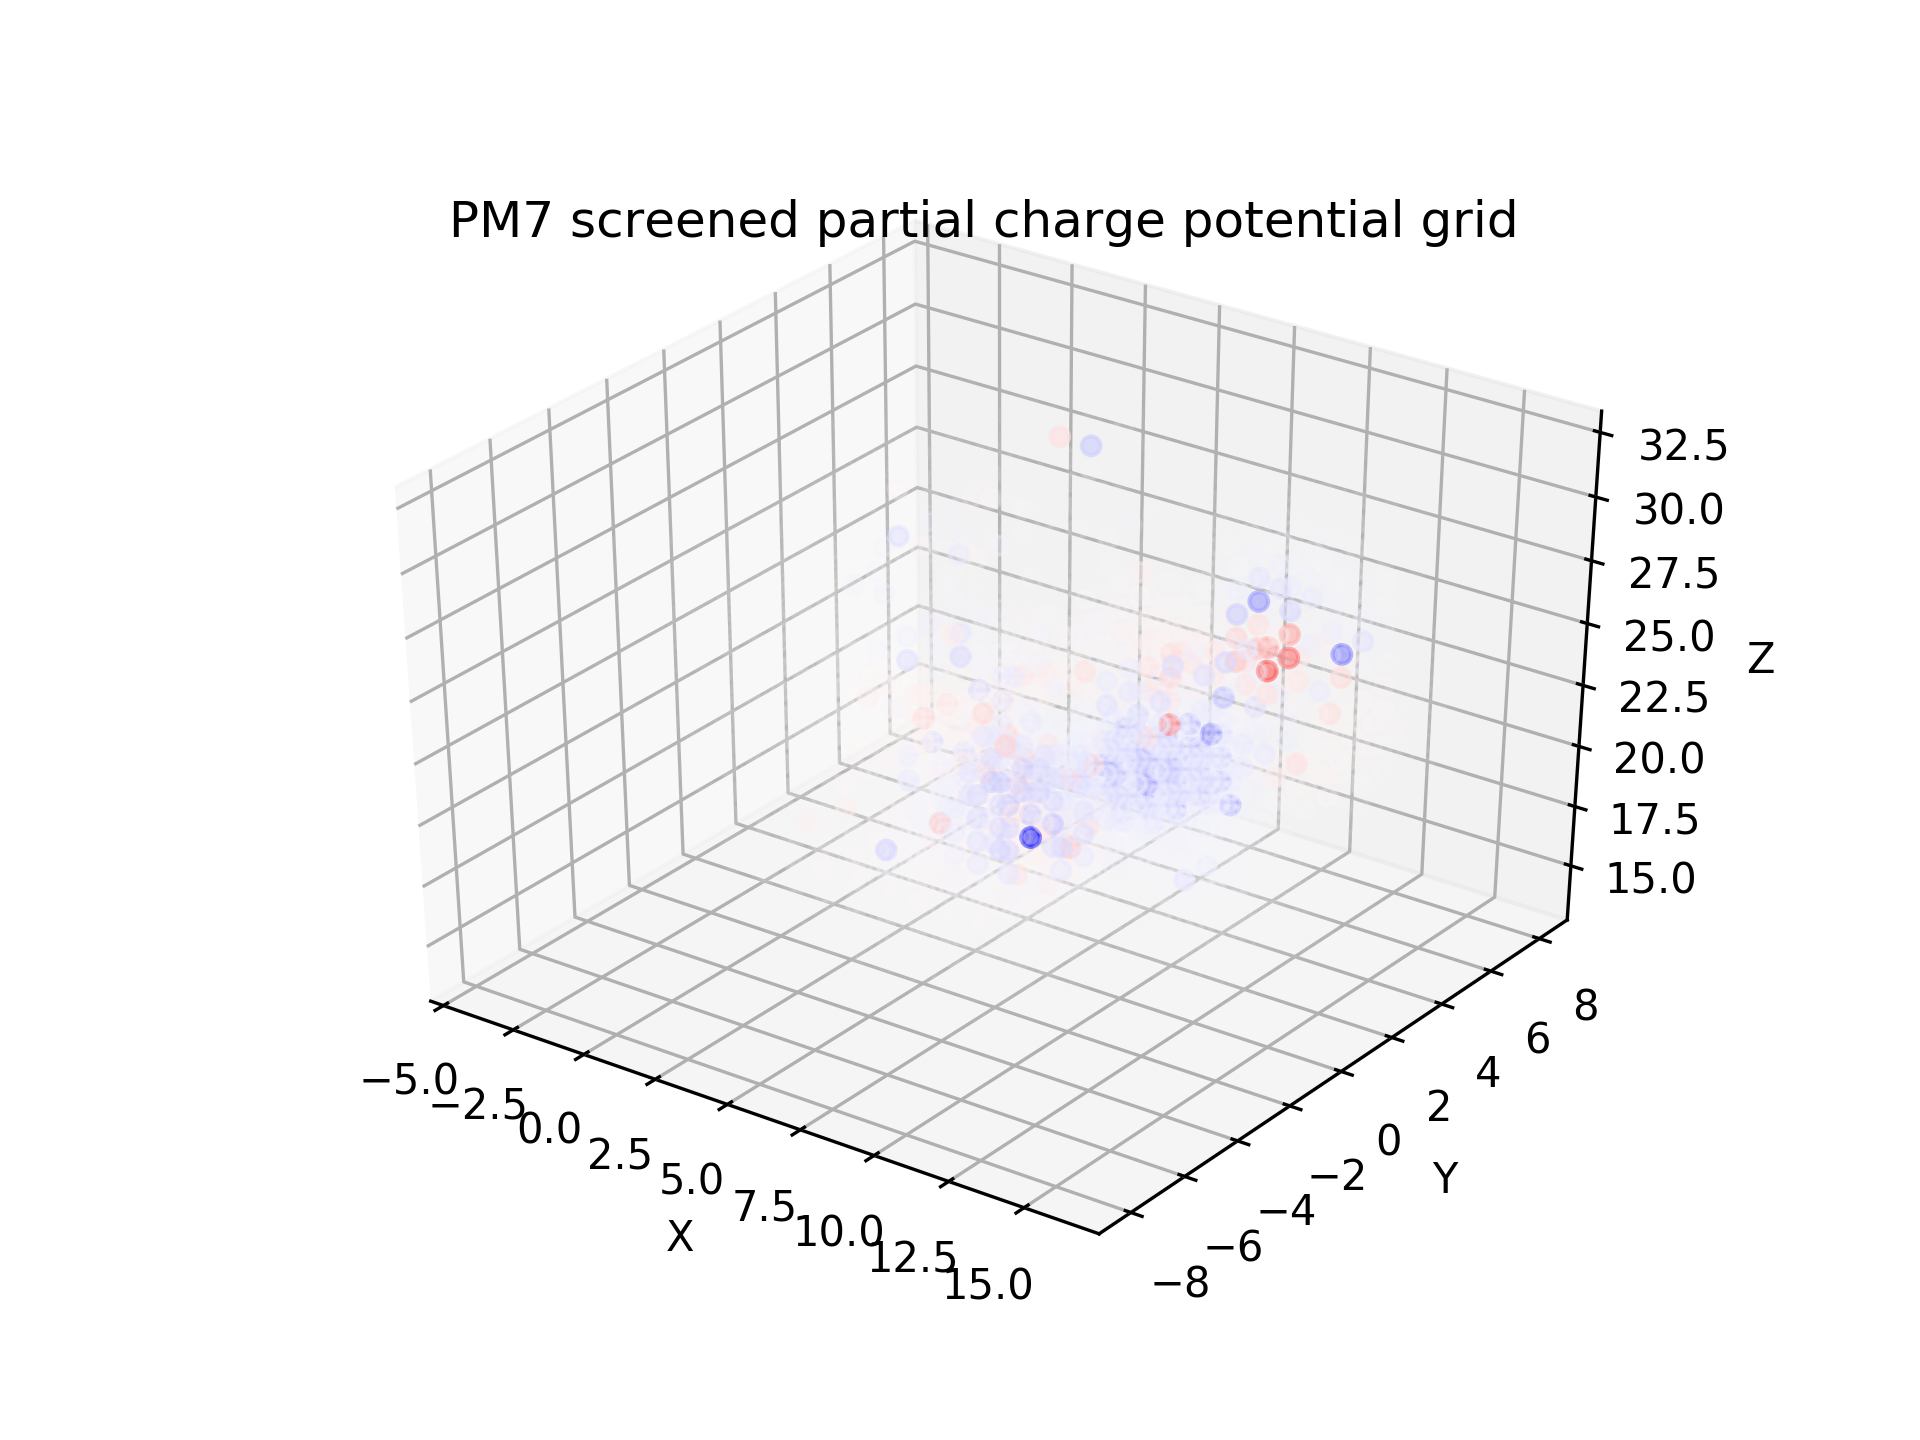

In [99]:
vmin = potential.min()
vmax = potential.max()

norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('PM7 screened partial charge potential grid')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
cm = plt.cm.get_cmap('bwr')

colors = cm(norm(potential))
potential = np.where(np.abs(potential)>1, 1, np.abs(potential))
alphas = np.abs(potential)/(potential.max()-potential.min())
alphas = np.where(alphas>1, 1, alphas)
colors[:,3] = alphas
#for i, j in enumerate(xv):
im = ax.scatter(xv, yv, zv, c=colors)#alpha=(potential[i]-vmin)/(vmax-vmin))

<IPython.core.display.Javascript object>


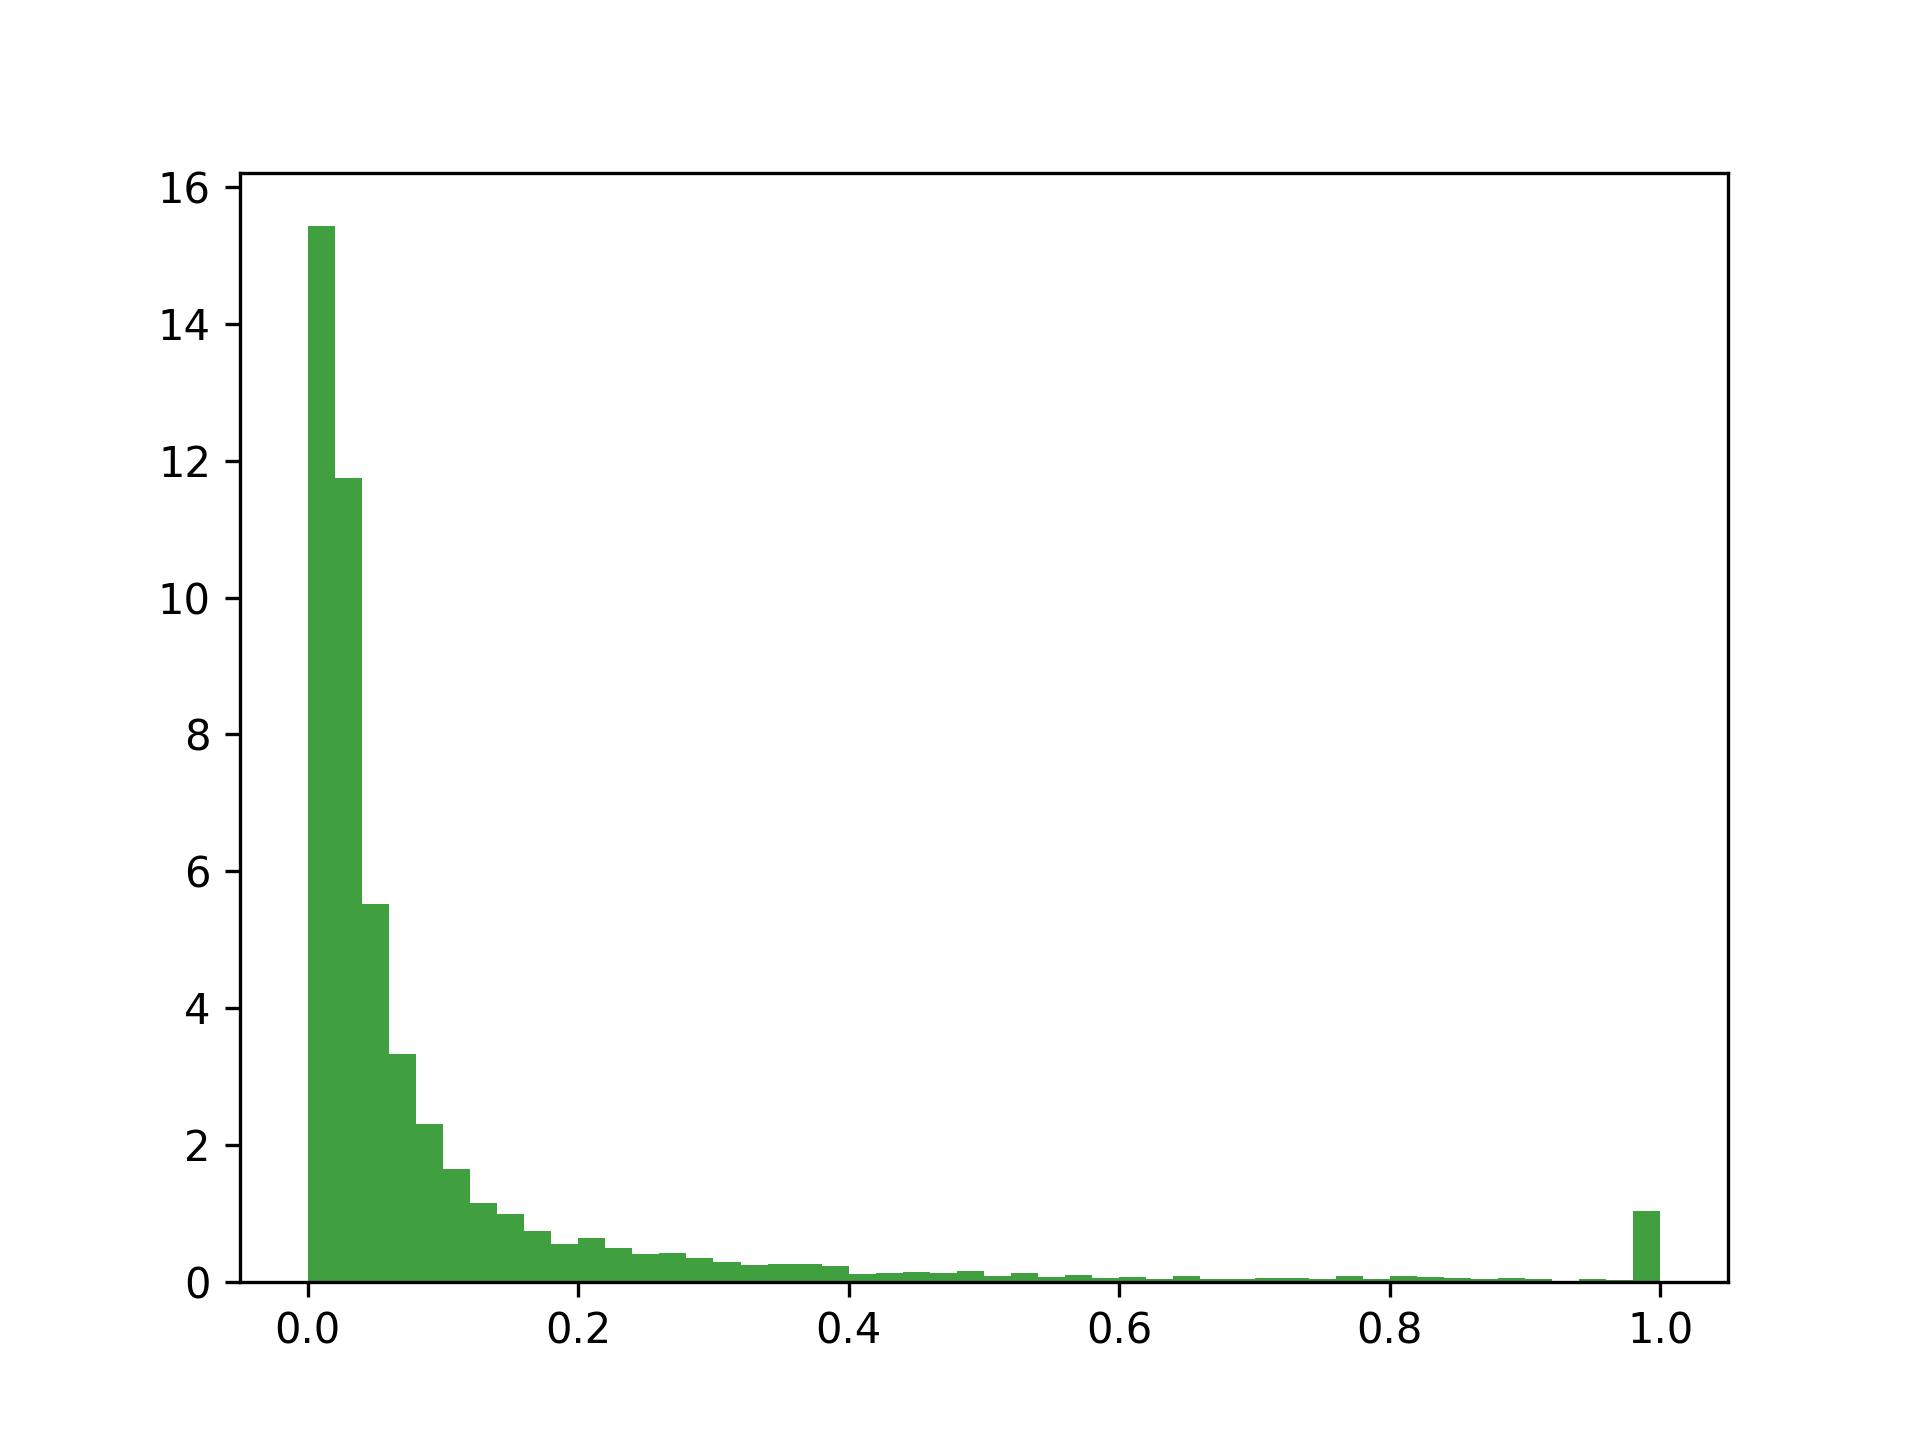

(array([1.54376025e+01, 1.17438280e+01, 5.51878666e+00, 3.33127213e+00,
        2.30626532e+00, 1.64376092e+00, 1.14375760e+00, 9.93756601e-01,
        7.37504899e-01, 5.43753612e-01, 6.43754276e-01, 4.93753280e-01,
        4.00002657e-01, 4.18752782e-01, 3.43752283e-01, 2.93751951e-01,
        2.37501578e-01, 2.56251702e-01, 2.50001661e-01, 2.25001495e-01,
        1.12500747e-01, 1.25000830e-01, 1.37500913e-01, 1.25000830e-01,
        1.56251038e-01, 8.75005812e-02, 1.31250872e-01, 6.87504567e-02,
        9.37506227e-02, 5.00003321e-02, 6.87504567e-02, 4.37502906e-02,
        7.50004982e-02, 3.75002491e-02, 3.75002491e-02, 5.00003321e-02,
        5.62503736e-02, 3.75002491e-02, 7.50004982e-02, 4.37502906e-02,
        8.12505397e-02, 6.87504567e-02, 5.00003321e-02, 3.12502076e-02,
        5.00003321e-02, 3.12502076e-02, 1.25000830e-02, 3.75002491e-02,
        2.50001661e-02, 1.03750689e+00]),
 array([6.64240237e-06, 2.00065096e-02, 4.00063767e-02, 6.00062439e-02,
        8.00061110e-02

In [102]:
fig = plt.figure()
plt.hist(potential, 50, density=True, facecolor='g', alpha=0.75)